# Project: COVID death rate and World Health Statistics by Jyothi Samudrala


Is covid death rate higher in countries where substance abuse is higher?

Is covid death rate higher in countries that have a high probability of death from non-communicable diseases?

Is covid death rate higher in countries that have high tobacco consumption?

Current news and studies may answer with a general “yes” to the above questions. However, my intent is to understand the true relation between death rate and some of the world health statistics; perhaps there are surprises that go against conventional understanding. 

## Cleaning and Creating Final Dataset

In [109]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import cov
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn import linear_model
import statsmodels.api as sm
from scipy.stats import ttest_1samp
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as stests


# Importing Covid Data by Country into a dataframe using Pandas
covid_df = pd.read_csv("country_wise_latest.csv") 

# Importing World Health Data into a dataframe using Pandas
noncommunicable_df = pd.read_csv("30-70cancerChdEtc.csv") 
alcoholabuse_df =  pd.read_csv("alcoholSubstanceAbuse.csv") 
householdexpenditure_df = pd.read_csv("population25SDG3.8.2.csv") 
tobaccousage_df = pd.read_csv("tobaccoAge15.csv") 

# Cleaning covid data
# Columns - Country, Death Rate and Recovery Rate
covid_df['Death Rate'] = 100*(covid_df['Deaths']/covid_df['Confirmed'])
covid_df['Recovery Rate'] = 100*(covid_df['Recovered']/covid_df['Confirmed'])
new_covid_df = covid_df[['Country/Region','Death Rate', 'Recovery Rate']]
new_covid_df.rename(columns = {'Country/Region':'Location'}, inplace = True)

# Cleaning world health data
# Cleaning the data representing probability of dying from non-communicable diseases between the age of 30 and 70
# Selecting data only for the most recent (and available) year 2016, for both sexes
new_noncommunicable_df = noncommunicable_df[(noncommunicable_df['Period']==2016) & (noncommunicable_df['Dim1']=="Both sexes")]
# Selecting only the relevant columns and renaming them
new_noncommunicable_df = new_noncommunicable_df[['Location', 'First Tooltip']]
new_noncommunicable_df.rename(columns = {'First Tooltip':'noncommunicabledeath_prob'}, inplace = True)

# Cleaning the data representing alcohol consumption per capita
# Selecting data only for the most recent (and available) year 2018, for both sexes
new_alcoholabuse_df = alcoholabuse_df[(alcoholabuse_df['Period']==2018) & (alcoholabuse_df['Dim1']=="Both sexes")]
# Selecting only the relevant columns and renaming them
new_alcoholabuse_df = new_alcoholabuse_df[['Location', 'First Tooltip']]
new_alcoholabuse_df.rename(columns = {'First Tooltip':'alcoholconsumption_percapita'}, inplace = True)

# Cleaning the data representing  population with household expenditures on health greater than 25% of total household expenditure or income
# Selecting data only for the most recent year 2016, for total (including urban and rural)
new_householdexpenditure_df = householdexpenditure_df[(householdexpenditure_df['Period']==2016) & (householdexpenditure_df['Dim1']=="Total")]
# Note: We will proceed further with this data as new_householdexpenditure_df as it only has 22 countries. 


# Cleaning the data representing tobacco use among persons aged 15 years and older
# Selecting data only for the most recent (and available) year 2018, for both sexes
new_tobaccousage_df = tobaccousage_df[(tobaccousage_df['Period']==2018) & (tobaccousage_df['Dim1']=="Both sexes")]
# Selecting only the relevant columns and renaming them
new_tobaccousage_df = new_tobaccousage_df[['Location', 'First Tooltip']]
new_tobaccousage_df.rename(columns = {'First Tooltip':'tobacco_usage'}, inplace = True)

# Creating the final dataset 
# Combining Covid data with non communicable dieases data, with Location (country) as key
combined_final_df = pd.merge(new_covid_df, new_noncommunicable_df, on='Location', how='outer')
# Combining above dataset with alcohol abuse data, with Location (country) as key
combined_final_df = pd.merge(combined_final_df, new_alcoholabuse_df, on='Location', how='outer')
# Combining above dataset with tobacco usage data, with Location (country) as key
combined_final_df = pd.merge(combined_final_df, new_tobaccousage_df, on='Location', how='outer')


# Dropping rows with nan values
combined_final_df = combined_final_df.dropna()




C:\Users\prate\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [108]:
# General info on the final data frame. We have 156 rows. 4 Columns. One Object datatype, and the rest are float64.
combined_final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 1 to 186
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Location                      126 non-null    object 
 1   Death Rate                    126 non-null    float64
 2   Recovery Rate                 126 non-null    float64
 3   noncommunicabledeath_prob     126 non-null    float64
 4   alcoholconsumption_percapita  126 non-null    float64
 5   tobacco_usage                 126 non-null    float64
dtypes: float64(5), object(1)
memory usage: 6.9+ KB


In [10]:
combined_final_df.head()


,Location,Death Rate,Recovery Rate,noncommunicabledeath_prob,alcoholconsumption_percapita,tobacco_usage
1,Albania,2.950820,56.250000,17.0,7.17,29.2
2,Algeria,4.157581,67.339935,14.2,0.95,18.8
6,Argentina,1.827185,43.350098,15.8,9.65,21.8
7,Armenia,1.901578,71.315860,22.3,5.55,26.7
8,Australia,1.091289,60.844279,9.1,10.51,16.2


In [107]:
# As indicated, there are no duplicates in the data
duplicates = combined_final_df.Location.value_counts()
 

In [106]:
# Descriptive Statistics for Each Column
descriptive_stats = combined_final_df.describe()
descriptive_stats
# Based on the descriptives stats, we the can rule that there are no outliers.

,Death Rate,Recovery Rate,noncommunicabledeath_prob,alcoholconsumption_percapita,tobacco_usage
count,126.000000,126.000000,126.000000,126.000000,126.000000
mean,3.238241,64.823299,18.099206,6.502643,21.100794
std,3.761617,25.679992,5.737825,4.210321,9.471334
min,0.000000,0.000000,8.400000,0.003000,3.700000
25%,1.200203,51.194676,13.100000,2.735000,12.925000
50%,2.271200,70.931837,17.800000,6.565000,21.800000
75%,3.946600,85.334334,22.275000,9.640000,27.100000
max,28.562980,98.327940,30.600000,20.500000,44.700000


## Creating a histogram of the variables in the final dataset


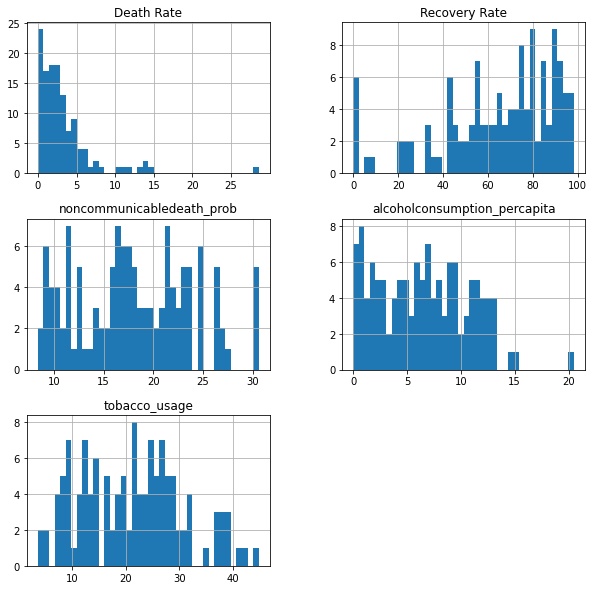

In [13]:
hist = combined_final_df.hist(bins=40, figsize=(10,10))

## PMF - Mapping PMF of all variables on each other

C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\prate\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\prate\anacond

[Text(0.5, 0, 'Normalized Values of all variables'),
 Text(0, 0.5, 'Probabilities'),
 Text(0.5, 1.0, 'PMF')]

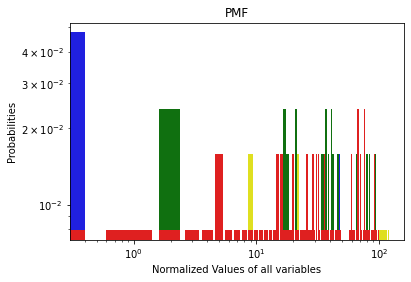

In [105]:
probabilities_deathrate = combined_final_df['Death Rate'].value_counts(normalize=True)    
g = sns.barplot(probabilities_deathrate.index, probabilities_deathrate.values, color='blue')


probabilities_nonc = combined_final_df['noncommunicabledeath_prob'].value_counts(normalize=True)    
g = sns.barplot(probabilities_nonc.index, probabilities_nonc.values, color='green')

probabilities_alcohol = combined_final_df['alcoholconsumption_percapita'].value_counts(normalize=True)   
g = sns.barplot(probabilities_alcohol.index, probabilities_alcohol.values, color='yellow')
 

probabilities_tobacco = combined_final_df['tobacco_usage'].value_counts(normalize=True)  
g = sns.barplot(probabilities_tobacco.index, probabilities_tobacco.values, color='red')

g.set_xscale("log")
g.set_yscale("log")
g.set(xlabel="Normalized Values of all variables", ylabel = "Probabilities", title="PMF" )

## PDF and CDF

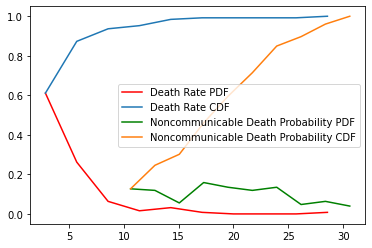

In [104]:
# getting data of the histogram
count, bins_count = np.histogram(combined_final_df['Death Rate'], bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="Death Rate PDF")
plt.plot(bins_count[1:], cdf, label="Death Rate CDF")
plt.legend()

# getting data of the histogram
count, bins_count = np.histogram(combined_final_df['noncommunicabledeath_prob'], bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="green", label="Noncommunicable Death Probability PDF")
plt.plot(bins_count[1:], cdf, label="Noncommunicable Death Probability CDF")
plt.legend()






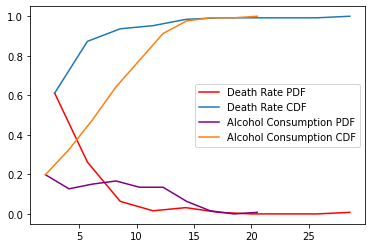

In [103]:
# getting data of the histogram
count, bins_count = np.histogram(combined_final_df['Death Rate'], bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="Death Rate PDF")
plt.plot(bins_count[1:], cdf, label="Death Rate CDF")
plt.legend()


# getting data of the histogram
count, bins_count = np.histogram(combined_final_df['alcoholconsumption_percapita'], bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="purple", label="Alcohol Consumption PDF")
plt.plot(bins_count[1:], cdf, label="Alcohol Consumption CDF")
plt.legend()


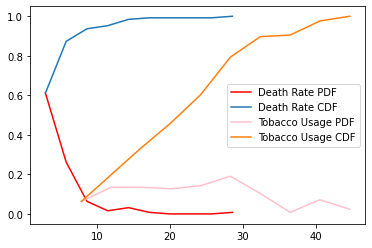

In [102]:
# getting data of the histogram
count, bins_count = np.histogram(combined_final_df['Death Rate'], bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="red", label="Death Rate PDF")
plt.plot(bins_count[1:], cdf, label="Death Rate CDF")
plt.legend()

# getting data of the histogram
count, bins_count = np.histogram(combined_final_df['tobacco_usage'], bins=10)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
cdf = np.cumsum(pdf)
  
# plotting PDF and CDF
plt.plot(bins_count[1:], pdf, color="pink", label="Tobacco Usage PDF")
plt.plot(bins_count[1:], cdf, label="Tobacco Usage CDF")
plt.legend()

## Scatter Plots and Fitted Line

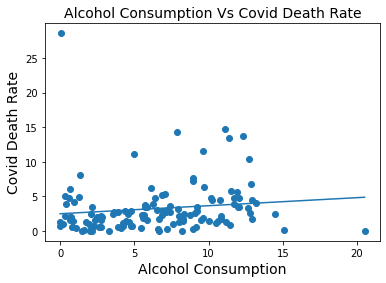

In [101]:
plt.scatter(combined_final_df['alcoholconsumption_percapita'], combined_final_df['Death Rate'] )
plt.plot(np.unique(combined_final_df['alcoholconsumption_percapita']), np.poly1d(np.polyfit(combined_final_df['alcoholconsumption_percapita'], combined_final_df['Death Rate'], 1))(np.unique(combined_final_df['alcoholconsumption_percapita'])))
plt.title('Alcohol Consumption Vs Covid Death Rate', fontsize=14)
plt.xlabel('Alcohol Consumption', fontsize=14)
plt.ylabel('Covid Death Rate', fontsize=14)
plt.show()

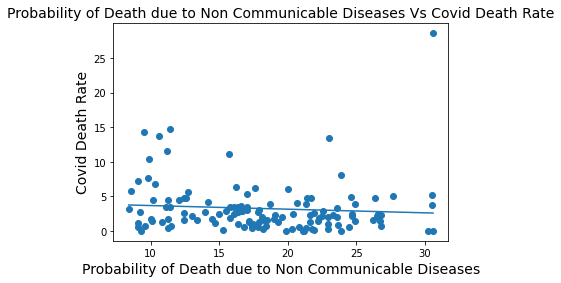

In [100]:
plt.scatter(combined_final_df['noncommunicabledeath_prob'], combined_final_df['Death Rate'])
plt.plot(np.unique(combined_final_df['noncommunicabledeath_prob']), np.poly1d(np.polyfit(combined_final_df['noncommunicabledeath_prob'], combined_final_df['Death Rate'], 1))(np.unique(combined_final_df['noncommunicabledeath_prob'])))
plt.title('Probability of Death due to Non Communicable Diseases Vs Covid Death Rate', fontsize=14)
plt.xlabel('Probability of Death due to Non Communicable Diseases', fontsize=14)
plt.ylabel('Covid Death Rate', fontsize=14)
plt.show()

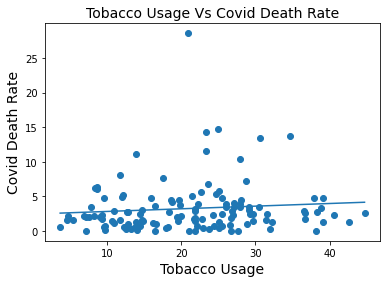

In [99]:
plt.scatter(combined_final_df['tobacco_usage'], combined_final_df['Death Rate'] )
plt.plot(np.unique(combined_final_df['tobacco_usage']), np.poly1d(np.polyfit(combined_final_df['tobacco_usage'], combined_final_df['Death Rate'], 1))(np.unique(combined_final_df['tobacco_usage'])))
plt.title('Tobacco Usage Vs Covid Death Rate', fontsize=14)
plt.xlabel('Tobacco Usage', fontsize=14)
plt.ylabel('Covid Death Rate', fontsize=14)
plt.show()

## Covariance, Pearsonr and Spearmanr

In [98]:
covariance_1 = cov(combined_final_df['alcoholconsumption_percapita'], combined_final_df['Death Rate'])
corr_p_1, _ = pearsonr(combined_final_df['alcoholconsumption_percapita'], combined_final_df['Death Rate'])
corr_s_1, _ = spearmanr(combined_final_df['alcoholconsumption_percapita'], combined_final_df['Death Rate'])
print("Covariance for alcoholconsumption_percapita: ",covariance_1)
print("Pearsonr for alcoholconsumption_percapita: ",corr_p_1)
print("Spearmanr for alcoholconsumption_percapita: ",corr_s_1)

Covariance for alcoholconsumption_percapita:  [[17.72680233  2.05870018]
 [ 2.05870018 14.14976161]]
Pearsonr for alcoholconsumption_percapita:  0.12998802336952864
Spearmanr for alcoholconsumption_percapita:  0.26418232845296885


In [97]:
covariance_2 = cov(combined_final_df['noncommunicabledeath_prob'], combined_final_df['Death Rate'])
corr_p_2, _ = pearsonr(combined_final_df['noncommunicabledeath_prob'], combined_final_df['Death Rate'])
corr_s_2, _ =  spearmanr(combined_final_df['noncommunicabledeath_prob'], combined_final_df['Death Rate'])
print("Covariance for noncommunicabledeath_prob: ",covariance_2)
print("Pearsonr for noncommunicabledeath_prob: ",corr_p_2)
print("Spearmanr for noncommunicabledeath_prob: ",corr_s_2)

Covariance for noncommunicabledeath_prob:  [[32.92263937 -1.72755122]
 [-1.72755122 14.14976161]]
Pearsonr for noncommunicabledeath_prob:  -0.08004036301776227
Spearmanr for noncommunicabledeath_prob:  -0.18269253846709124


In [96]:
covariance_3 = cov(combined_final_df['tobacco_usage'], combined_final_df['Death Rate'])
corr_p_3, _ = pearsonr(combined_final_df['tobacco_usage'], combined_final_df['Death Rate'])
corr_s_3, _ = spearmanr(combined_final_df['tobacco_usage'], combined_final_df['Death Rate'])
print("Covariance for tobacco_usage: ",covariance_3)
print("Pearsonr for tobacco_usage: ",corr_p_3)
print("Spearmanr for tobacco_usage: ",corr_s_3)

Covariance for tobacco_usage:  [[89.70615937  3.43526956]
 [ 3.43526956 14.14976161]]
Pearsonr for tobacco_usage:  0.09642177636969855
Spearmanr for tobacco_usage:  0.13157515794838082


## Hypothesis Testing - One Sample T test and Z Test

In [93]:
alcohol_mean = np.mean(combined_final_df['alcoholconsumption_percapita'])
print("alcohol consumption mean", alcohol_mean)
tset, pval = ttest_1samp(combined_final_df['alcoholconsumption_percapita'], 30)
print(" For alcohol consumption...")

if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

alcohol consumption mean 6.502642857142857
 For alcohol consumption...
 we are rejecting null hypothesis


In [94]:
noncommunicable_mean = np.mean(combined_final_df['noncommunicabledeath_prob'])
print("Non Communicable disease mean: ", noncommunicable_mean)
tset, pval = ttest_1samp(combined_final_df['noncommunicabledeath_prob'], 30)
print(" For Non Communicable disease...")

if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

Non Communicable disease mean:  18.099206349206348
 For Non Communicable disease...
 we are rejecting null hypothesis


In [95]:
tobacco_mean = np.mean(combined_final_df['tobacco_usage'])
print("Tobacco mean: ", tobacco_mean)
tset, pval = ttest_1samp(combined_final_df['tobacco_usage'], 30)
print(" For Tobacco Usage...")


if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

Tobacco mean:  21.100793650793666
 For Tobacco Usage...
 we are rejecting null hypothesis


In [89]:

ztest ,pval = stests.ztest(combined_final_df['alcoholconsumption_percapita'], x2=None, value=156)
print(" For alcohol consumption...")

if pval<0.05:
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

 For alcohol consumption...
 we are rejecting null hypothesis


In [90]:

ztest ,pval = stests.ztest(combined_final_df['noncommunicabledeath_prob'], x2=None, value=156)
print(" For Non Communicable disease...")

if pval<0.05:
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

 For Non Communicable disease...
 we are rejecting null hypothesis


In [91]:

ztest ,pval = stests.ztest(combined_final_df['tobacco_usage'], x2=None, value=156)
print(" For Tobacco Usage...")

if pval<0.05:
   print(" we are rejecting null hypothesis")
else:
  print("we are accepting null hypothesis")

 For Tobacco Usage...
 we are rejecting null hypothesis


## Multiple Regression Analysis

In [49]:
X = combined_final_df[['tobacco_usage','noncommunicabledeath_prob','alcoholconsumption_percapita']]
Y = combined_final_df['Death Rate']
 
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 2.694069500408635
Coefficients: 
 [ 0.02803449 -0.03397567  0.08728047]


In [53]:
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             Death Rate   R-squared (uncentered):                   0.427
Model:                            OLS   Adj. R-squared (uncentered):              0.413
Method:                 Least Squares   F-statistic:                              30.49
Date:                Sat, 05 Jun 2021   Prob (F-statistic):                    8.27e-15
Time:                        15:36:04   Log-Likelihood:                         -345.33
No. Observations:                 126   AIC:                                      696.7
Df Residuals:                     123   BIC:                                      705.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
tobacco_usage                    0.0528      0.034      1.535      0.127      -0.015       0.121
noncommunicabledeath_prob        0.0542      0.036      1.493      0.138      -0.018       0.126
alcoholconsumption_percapita     0.1554      0.078      1.995      0.048       0.001       0.310
==============================================================================
Omnibus:                      120.862   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1729.605
Skew:                           3.322   Prob(JB):                         0.00
Kurtosis:                      19.891   Cond. No.                         7.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Death Rate   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9852
Date:                Sat, 05 Jun 2021   Prob (F-statistic):              0.402
Time:                        15:37:09   Log-Likelihood:                -343.71
No. Observations:                 126   AIC:                             695.4
Df Residuals:                     122   BIC:                             706.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            2.6941      1.509      1.785      0.077      -0.293       5.681
tobacco_usage                    0.0280      0.037      0.762      0.448      -0.045       0.101
noncommunicabledeath_prob       -0.0340      0.061     -0.556      0.579      -0.155       0.087
alcoholconsumption_percapita     0.0873      0.086      1.013      0.313      -0.083       0.258
==============================================================================
Omnibus:                      130.949   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2304.743
Skew:                           3.651   Prob(JB):                         0.00
Kurtosis:                      22.639   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""